Käesolevas magistritöös oli eesmärgiks ehitada veebiämblik, mis leiaks üles ja laadiks alla Perekooli foorumist teema “Laps“ alamteema „Koolilaps“  all olevate postituste tekstid koos lisainfoga (kuupäev, teema, kasutaja id).
Töö sai läbi viidud kolmes etapis:
•	Tarkvara algoritmi koostamine
•	Tarkvara loomine ja testimine
•	Andmete allalaadimine

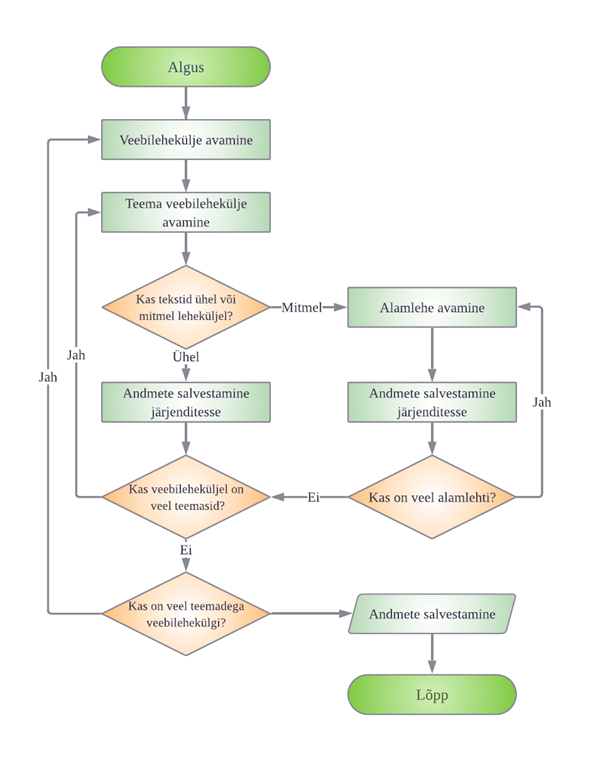

In [24]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/magister/"
Image(filename = PATH + "veebiamblik.png")


In [1]:
import requests
import re
import time
from bs4 import BeautifulSoup
from collections import defaultdict
import json

In [27]:
lk =2
lk2=2
lehekylg =1
alam_lk =1
sub_aadress =""
artikkel_id =[]
teemad = []
tekstid = []
kuupaevad =[]
kasutajad = []
pattern2 ='user-id\-\d+'
pattern3 ='\d+'
algaadress ='https://foorum.perekool.ee/foorum/koolilaps/'
veebiaadress = 'https://foorum.perekool.ee/foorum/koolilaps/'
headers = requests.utils.default_headers()
headers.update(
  { 'User-Agent': 'my crawler (teet.kalmus@gmail.com) / on studying purpose', }
)#määran päringu päises enda identiteedi
def andmed_jarjenditesse(artikkel, teema, soup):
    for kood in soup(["script", "style", "blockquote"]):#kustutan segava koodi
        kood.decompose()
    for segav_klass in soup('div', {'class': 'varemkirjutanud'}):#kustutame segavad klassid
        segav_klass.decompose()
    for segav_klass in soup('div', {'class': 'gdrts-rating-please-wait'}):
        segav_klass.decompose()
    for segav_klass in soup('h4', {'class': 'bbp-reply-title'}):
        segav_klass.decompose()
    for segav_klass in soup('em', {'class': 'gdbbx-bbcode-italic'}):
        segav_klass.decompose()
    data_kasutaja=soup.find_all('div', {'class': re.compile(r'^loop-item\-\d+')})#võtan koodist välja kasutaja id
    for a in data_kasutaja:
        kasutaja_id =' '.join(map(str, re.findall(pattern2,str(a))))
        kasutaja_id_puhas =' '.join(map(str, re.findall(pattern3,kasutaja_id)))
        kasutajad.append(kasutaja_id_puhas)#lisame kasutaja järjendisse
    data2 = soup.find_all('div', {'class': 'post_date date updated'})
    for i in data2:
        postitus_aeg = (i.text).replace('\n', '')#korrastame andmed
        kuupaevad.append(postitus_aeg)#lisame postituse kuupäeva järjendisse
    data2a = soup.find_all('div', {'class': 'bbp-reply-content entry-content'})
    for i in data2a:
        teemad.append(teema)#lisame teema järjendisse
        artikkel_id.append(artikkel)
        postitus_tekst = (i.text).replace('\n', '')
        if '[/tsitaat]' in postitus_tekst:#kui tekstis on eelmistest postitustest korduv tekst
            f_split = re.split(r'[/]\w+\D',postitus_tekst)
            postitus_tekst = f_split[1]
            tekstid.append(postitus_tekst)#lisame teksti järjendisse        
        else:
            tekstid.append(postitus_tekst)#lisame teksti järjendisse
    return
def viimane_lk(lk_data):
    maks =0
    for numbers in lk_data:#leian viimase lehekülje numbri
        number = numbers.text
        if number.isnumeric(): 
            if int(number) > maks:
                maks = int(number)
    return(maks)
response = requests.get(veebiaadress, headers =headers)
content = response.text
soup = BeautifulSoup(content, 'html.parser')
viimase_lk_data = soup.find_all('a', {'class':'page-numbers'})
viimane =viimane_lk(viimase_lk_data)
while lehekylg <= viimane:
    print(veebiaadress)#visuaalne indikatsioon programmi tööst
    response = requests.get(veebiaadress, headers =headers)
    content = response.text
    soup = BeautifulSoup(content, 'html.parser')#parsime veebilehe sisu
    time.sleep(1)#tekitame sekundilise pausi, et serverit mitte üle koormata
    lehekylg +=1
    data = soup.find_all('a', {'class': 'bbp-topic-permalink'})
    for i in data:    
        aadress =i['href']
        teema = i.text
        time.sleep(1)#tekitame pausi, et serverit mitte üle koormata
        response = requests.get(aadress, headers=headers)
        content = response.text
        soup = BeautifulSoup(content, 'html.parser')
        data_soup = soup.find_all('article')
        for i in data_soup:
            artikkel =' '.join(map(str,re.findall(pattern3,(i['class'])[0])))#leiame artikli id
        andmed_jarjenditesse(artikkel,teema, soup)   
        data3 = soup.find_all('a', {'class': 'page-numbers'})#vaatame, kas on alamlehti
        alam_maks =viimane_lk(data3)
        sub_aadress = aadress  + 'page/2/'            
        while alam_lk <= alam_maks:#alamlehtede jaoks tegin teise while-tsükli
            if alam_lk == alam_maks:
                alam_lk =1
                lk2=2
                alam_maks =0
                del sub_aadress#kustutame sub_aadressi, et järgmisel korral ei jääks segama
                break
            else:
                time.sleep(1)#tekitame pausi, et serverit mitte üle koormata
                response = requests.get(sub_aadress, headers=headers)
                content = response.text
                soup2 = BeautifulSoup(content, 'html.parser')
                alam_lk +=1
                print("alamlehekülg" + str(alam_lk))
                andmed_jarjenditesse(artikkel, teema, soup2)
                print(sub_aadress)
                lk2 +=1
                sub_aadress = aadress + 'page/'+str(lk2) + '/'       
    if veebiaadress == algaadress:#loome uued veebiaadressid
        veebiaadress = algaadress + 'page/2/'
    else:
        lk +=1
        veebiaadress = algaadress + 'page/'+str(lk) + '/'


In [ ]:
with open('koolilaps_andmed.json', 'w') as fout:#kirjutame andmed faili
    for artid,teema, kasutaja, kuup,tekst in zip(artikkel_id,teemad, kasutajad, kuupaevad,tekstid):
        mida = artid, teema, kasutaja, kuup,tekst
        print(mida)
        json.dump(mida,fout)
        fout.write('\n')